In [193]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random

infile = "results.pkl"
outfile = "perfChanges.pkl"
outfile2 = "accuracy.pkl"
rawData = []
accuracy = []
min_results = 5
max_results = 1501
step = 5 
samples = 10000
CI99 = 100 - 99 # 99% conf
df_results = pd.read_pickle(infile)

In [194]:
platforms = df_results.platform.unique()
ci_duet_cpu_0 = []
ci_duet_cpu_5 = []
ci_fb_cpu_0 = []
ci_fb_cpu_5 = []
ci_trad_cpu_0 = []
ci_trad_cpu_5 = []

ci_duet_mem_0 = []
ci_duet_mem_5 = []
ci_fb_mem_0 = []
ci_fb_mem_5 = []
ci_trad_mem_0 = []
ci_trad_mem_5 = []


for result_count in range(min_results,max_results,step):
    print(result_count)
    platform = "aws"
    #print("analysis for platform " + platform + " ...")
    functionTypes = df_results.functionType.unique()
    for functionType in functionTypes:
        #print("analysis for type " + str(functionType) + "...")
        regressions = df_results.regression.unique()
        for regression in regressions:
            #print("analysis for regression " + str(regression) + "% ...")

            duetRun1 = (df_results.loc[(df_results["mode"] == 'duet')
                                        & (df_results["platform"] == "aws")
                                        & (df_results["functionType"] == functionType)
                                        & (df_results["regression"] == regression), 'f1'].to_numpy())[:result_count]
            duetRun2 = (df_results.loc[(df_results["mode"] == 'duet')
                                        & (df_results["platform"] == "aws")
                                        & (df_results["functionType"] == functionType)
                                        & (df_results["regression"] == regression),'f2'].to_numpy())[:result_count]
            duetChanges = (df_results.loc[(df_results["mode"] == 'duet')
                                        & (df_results["platform"] == "aws")
                                        & (df_results["functionType"] == functionType)
                                        & (df_results["regression"] == regression), 'change'].to_numpy())[:result_count]
            
            medPerfChange = (np.median(duetChanges) - 1) * 100
            manySamples = []
            for i in range (0,samples):
                simulatedExperiment = random.choices(duetChanges, k=len(duetChanges))
                manySamples.append(np.median(simulatedExperiment))

            manySamples.sort()

            #medPerfChange = (manySamples[int(len(manySamples)/2)] - 1) * 100
            small = int((samples * CI99) / 100 / 2)
            if small == 0:
                small  = 1
            min = manySamples[small]
            min = (min - 1) * 100
            max = manySamples[samples-small-1]
            max = (max - 1) * 100
            if (platform =="aws" and functionType == "cpu" and str(regression) == "5"):
                ci_duet_cpu_5.append(abs(max-min))
            elif(platform =="aws" and functionType == "cpu" and str(regression) == "0"):
                ci_duet_cpu_0.append(abs(max-min))
            elif(platform =="aws" and functionType == "mem" and str(regression) == "0"):
                ci_duet_mem_0.append(abs(max-min))
            else:
                ci_duet_mem_5.append(abs(max-min))
            row = {}
            row["platform"] = platform
            row["functionType"] = functionType
            row["regression"] = regression
            row["method"] = "DuetFaaS"
            row["change"] = medPerfChange
            row["min"] = min
            row["max"] = max
            row["resultCount"] = result_count
            rawData.append(row)
            row2 = {}
            row2["method"] = "DuetFaaS"
            row2["regression"] = regression
            row2["measurements"] = len(duetChanges)
            row2["deviation"] = abs(medPerfChange-regression)
            row2["CIWidth"] = abs(max-min)
            row2["resultCount"] = result_count
            accuracy.append(row2)

            faasterCI = abs(max-min)
            

            #faasterBench
            changes = (df_results.loc[(df_results["mode"] == 'modeA')
                                        & (df_results["platform"] == platform)
                                        & (df_results["functionType"] == functionType)
                                        & (df_results["regression"] == regression), 'change'].to_numpy())[:result_count]
            run1 = (df_results.loc[(df_results["mode"] == 'modeA')
                                        & (df_results["platform"] == platform)
                                        & (df_results["functionType"] == functionType)
                                        & (df_results["regression"] == regression),'f1'].to_numpy())[:result_count]
            run2 = (df_results.loc[(df_results["mode"] == 'modeA')
                                        & (df_results["platform"] == platform)
                                        & (df_results["functionType"] == functionType)
                                        & (df_results["regression"] == regression),'f2'].to_numpy())[:result_count]

            medPerfChange = (np.median(changes) - 1) * 100
            manySamples = []
            for i in range (0,samples):
                simulatedExperiment = random.choices(changes, k=len(changes))
                manySamples.append(np.median(simulatedExperiment))

            manySamples.sort()

            #medPerfChange = (manySamples[int(len(manySamples)/2)] - 1) * 100
            small = int((samples * CI99) / 100 / 2)
            if small == 0:
                small  = 1
            min = manySamples[small]
            min = (min - 1) * 100
            max = manySamples[samples-small-1]
            max = (max - 1) * 100
            if (platform =="aws" and functionType == "cpu" and str(regression) == "5"):
                ci_fb_cpu_5.append(abs(max-min))
            elif(platform =="aws" and functionType == "cpu" and str(regression) == "0"):
                ci_fb_cpu_0.append(abs(max-min))
            elif(platform =="aws" and functionType == "mem" and str(regression) == "0"):
                ci_fb_mem_0.append(abs(max-min))
            else:
                ci_fb_mem_5.append(abs(max-min))
            row = {}
            row["platform"] = platform
            row["platform"] = platform
            row["functionType"] = functionType
            row["regression"] = regression
            row["method"] = "faasterBench"
            row["change"] = medPerfChange
            row["min"] = min
            row["max"] = max
            row["resultCount"] = result_count
            rawData.append(row)

            row2 = {}
            row2["method"] = "faasterBench"
            row2["regression"] = regression
            row2["measurements"] = len(changes)
            row2["deviation"] = abs(medPerfChange-regression)
            row2["CIWidth"] = abs(max-min)
            row2["resultCount"] = result_count
            accuracy.append(row2)

            faasterCI = abs(max-min)


            # traditional
            durations1 = (df_results.loc[(df_results["mode"] == 'modeB')
                                        & (df_results["platform"] == platform)
                                        & (df_results["functionType"] == functionType)
                                        & (df_results["regression"] == regression),'f1'].to_numpy())[:result_count]
            durations2 = (df_results.loc[(df_results["mode"] == 'modeC')
                                    & (df_results["platform"] == platform)
                                        & (df_results["functionType"] == functionType)
                                        & (df_results["regression"] == regression),'f2'].to_numpy())[:result_count]


            durations1.sort()
            durations2.sort()
            pairs = []
            for d1 in durations1:
                for d2 in durations2:
                    pairs.append(d2/d1)

            #medPerf1 = np.median(durations1)
            #medPerf2 = np.median(durations2)
            #medPerfChange = ((medPerf2 / medPerf1) - 1) * 100

            medPerfChange = (np.median(pairs) - 1 ) * 100

            manySamples = []
            for i in range (0,samples):
                simulatedExperiment = []
                for i in range(0,len(durations1)):
                    simulatedExperiment.append(random.choice(durations2) / random.choice(durations1))

                manySamples.append(np.median(simulatedExperiment))

            manySamples.sort()

            #medPerfChange = (manySamples[int(len(manySamples)/2)] - 1) * 100
            small = int((samples * CI99) / 100 / 2)
            if small == 0:
                small  = 1
            min = manySamples[small]
            min = (min - 1) * 100
            max = manySamples[samples-small-1]
            max = (max - 1) * 100
            if (platform =="aws" and functionType == "cpu" and str(regression) == "5"):
                ci_trad_cpu_5.append(abs(max-min))
            elif(platform =="aws" and functionType == "cpu" and str(regression) == "0"):
                ci_trad_cpu_0.append(abs(max-min))
            elif(platform =="aws" and functionType == "mem" and str(regression) == "0"):
                ci_trad_mem_0.append(abs(max-min))
            else:
                ci_trad_mem_5.append(abs(max-min))
            
            row = {}
            row["platform"] = platform
            row["functionType"] = functionType
            row["regression"] = regression
            row["method"] = "traditional"
            row["change"] = medPerfChange
            row["min"] = min
            row["max"] = max
            row["resultCount"] = result_count
        
            rawData.append(row)

            row2 = {}
            row2["method"] = "traditional"
            row2["regression"] = regression
            row2["measurements"] = len(durations1)
            row2["deviation"] = abs(medPerfChange-regression)
            row2["CIWidth"] = abs(max-min)
            row2["resultCount"] = result_count
            accuracy.append(row2)
            tradCI = abs(max-min)

f1values = (df_results.loc[(df_results["mode"] == 'duet')
                        & (df_results["platform"] == "aws")
                        & (df_results["functionType"] == "cpu")
                        & (df_results["regression"] == 5),'f1'].to_numpy())[:result_count]
f2values = (df_results.loc[(df_results["mode"] == 'duet')
                        & (df_results["functionType"] == "cpu")
                        & (df_results["platform"] == "aws")
                        & (df_results["regression"] == 5),'f2'].to_numpy())[:result_count]

f1values0 = (df_results.loc[(df_results["mode"] == 'duet')
                        & (df_results["platform"] == "aws")
                        & (df_results["functionType"] == "cpu")
                        & (df_results["regression"] == 0),'f1'].to_numpy())[:result_count]
f2values0 = (df_results.loc[(df_results["mode"] == 'duet')
                        & (df_results["platform"] == "aws")
                        & (df_results["functionType"] == "cpu")
                        & (df_results["regression"] == 0),'f2'].to_numpy())[:result_count]



5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
1220

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


300
300


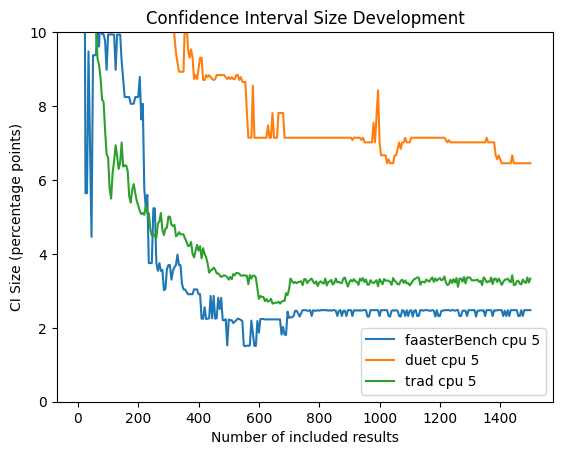

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


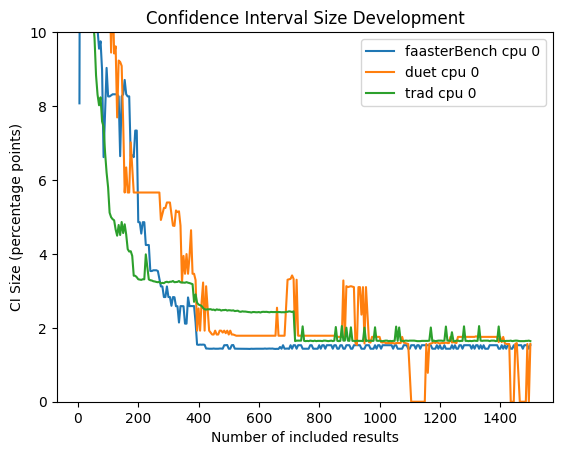

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


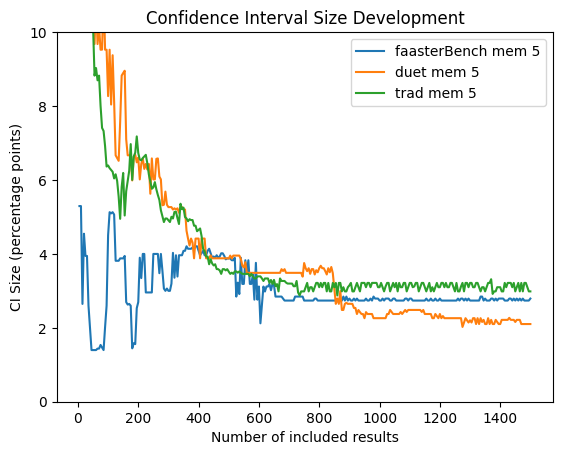

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


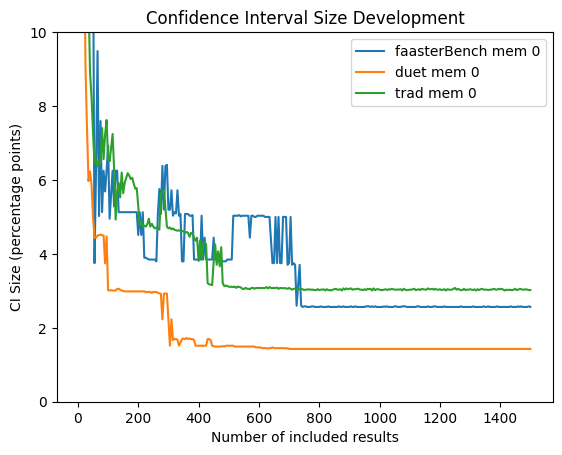

In [178]:
plt.title("Confidence Interval Size Development")
plt.legend()
plt.xlabel("Number of included results")
plt.ylabel("CI Size (percentage points)")
plt.ylim(0,10)
reg_values = 5
x_limits = range(reg_values,max_results,5)
print(len(x_limits))
print(len(ci_duet_cpu_0))
sns.lineplot(x= x_limits,y = ci_fb_cpu_5, label= "faasterBench cpu 5")
sns.lineplot(x= x_limits,y = ci_duet_cpu_5, label="duet cpu 5")
sns.lineplot(x= x_limits,y = ci_trad_cpu_5, label="trad cpu 5")
plt.show()

plt.title("Confidence Interval Size Development")
plt.legend()
plt.xlabel("Number of included results")
plt.ylabel("CI Size (percentage points)")
plt.ylim(0,10)
sns.lineplot(x= x_limits,y = ci_fb_cpu_0, label= "faasterBench cpu 0")
sns.lineplot(x= x_limits,y = ci_duet_cpu_0, label="duet cpu 0")
sns.lineplot(x= x_limits,y = ci_trad_cpu_0, label="trad cpu 0")
plt.show()


plt.title("Confidence Interval Size Development")
plt.legend()
plt.xlabel("Number of included results")
plt.ylabel("CI Size (percentage points)")
plt.ylim(0,10)
sns.lineplot(x= x_limits,y = ci_fb_mem_5, label= "faasterBench mem 5")
sns.lineplot(x= x_limits,y = ci_duet_mem_5, label="duet mem 5")
sns.lineplot(x= x_limits,y = ci_trad_mem_5, label="trad mem 5")
plt.show()


plt.title("Confidence Interval Size Development")
plt.legend()
plt.xlabel("Number of included results")
plt.ylabel("CI Size (percentage points)")
plt.ylim(0,10)
sns.lineplot(x= x_limits,y = ci_fb_mem_0, label= "faasterBench mem 0")
sns.lineplot(x= x_limits,y = ci_duet_mem_0, label="duet mem 0")
sns.lineplot(x= x_limits,y = ci_trad_mem_0, label="trad mem 0")
plt.show()



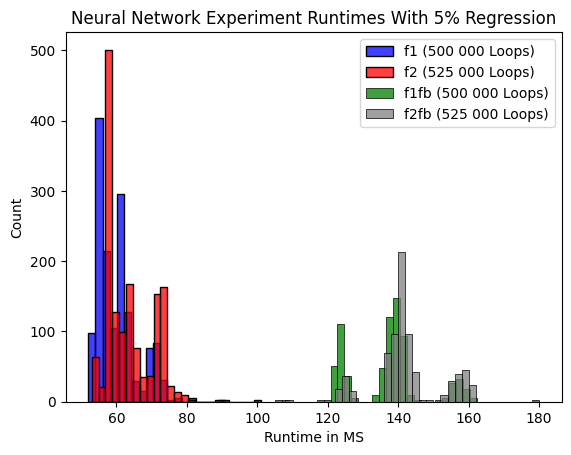

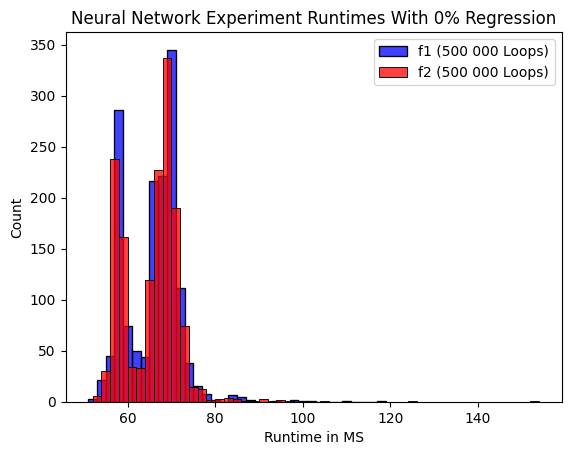

In [183]:
f1valuesfb = (df_results.loc[(df_results["mode"] == 'modeA')
                        & (df_results["platform"] == "aws")
                        & (df_results["functionType"] == "cpu")
                        & (df_results["regression"] == 5),'f1'].to_numpy())[:result_count]
f2valuesfb = (df_results.loc[(df_results["mode"] == 'modeA')
                        & (df_results["platform"] == "aws")
                        & (df_results["functionType"] == "cpu")
                        & (df_results["regression"] == 5),'f2'].to_numpy())[:result_count]
plt.xlabel("Runtime in MS")

sns.histplot(f1values, binwidth=2, color="blue", label="f1 (500 000 Loops)")
sns.histplot(f2values, binwidth=2, color="red", label="f2 (525 000 Loops)")
sns.histplot(f1valuesfb, binwidth=2, color="green", label="f1fb (500 000 Loops)")
sns.histplot(f2valuesfb, binwidth=2, color="gray", label="f2fb (525 000 Loops)")
plt.legend()
plt.title("Neural Network Experiment Runtimes With 5% Regression")
plt.show()
plt.xlabel("Runtime in MS")
plt.title("Neural Network Experiment Runtimes With 0% Regression")
sns.histplot(f1values0, binwidth=2, color="blue", label="f1 (500 000 Loops)")
sns.histplot(f2values0, binwidth=2, color="red", label="f2 (500 000 Loops)")
plt.legend()
plt.show()

In [192]:
print(f"fb avg size at 1500 : {(ci_fb_mem_0[150]+ci_fb_mem_5[150]+ci_fb_cpu_0[150])/3}")
print(f"duet avg size at 1500 : {(ci_duet_mem_0[150]+ci_duet_mem_5[150]+ci_duet_cpu_0[150])/3}")
print(f"trad avg size at 1500 : {(ci_trad_mem_0[150]+ci_trad_mem_5[150]+ci_trad_cpu_0[150])/3}")

fb avg size at 1500 : 2.2504840751104003
duet avg size at 1500 : 2.2754667301763636
trad avg size at 1500 : 2.5896071038128334


In [149]:


df_changes = pd.DataFrame(rawData)
df_changes.sort_values("platform", inplace=True)
df_changes.head()
df_changes.describe()
df_changes.to_pickle(outfile)

In [150]:
df_accuracy = pd.DataFrame(accuracy)
df_accuracy.head()
df_accuracy.describe()
df_accuracy.to_pickle(outfile2)
